In [19]:
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
import gc

In [20]:
DATA_DIR = r'C:\Users\Emily\Documents\Bachelor_Drohnen_Bilder\mask\splitted'

x_train_dir = os.path.join(DATA_DIR, 'train', "img")
y_train_dir = os.path.join(DATA_DIR, 'train', "mask")

x_valid_dir = os.path.join(DATA_DIR, 'valid', "img")
y_valid_dir = os.path.join(DATA_DIR, 'valid', "mask")

x_test_dir = os.path.join(DATA_DIR, 'test', "img")
y_test_dir = os.path.join(DATA_DIR, 'test', "mask")

In [21]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [22]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ["himmel", "strand", "wasser", "unlabelled"] #class_value 0 = himmel
    look_up = {
        0: 76,
        1: 149,
        2: 29,
        3:0
    }
    #CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
    #           'tree', 'signsymbol', 'fence', 'car',
    #           'pedestrian', 'bicyclist', 'unlabelled']


    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        try:
            self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        except TypeError:
            self.class_values = [0,1,2]
        for idx, val in enumerate(self.class_values):
            self.class_values[idx] = self.look_up[val]


        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [28]:
#dataset = Dataset(x_train_dir, y_train_dir, ["himmel", "strand", "wasser", "unlabelled"])
dataset = Dataset(x_train_dir, y_train_dir)

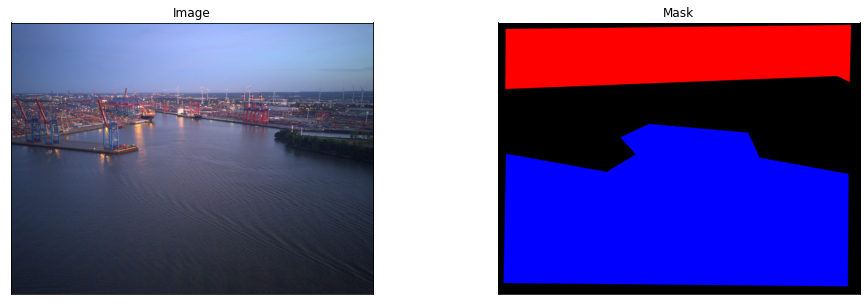

In [29]:
image, mask = dataset[0]  # get some sample
visualize(
    image=image,
    mask=mask.squeeze(),
)

In [23]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [24]:
augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
)

c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\albumentations\imgaug\transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\albumentations\imgaug\transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\albumentations\augmentations\transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\albumentations\imgaug\transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  

In [25]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [26]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["himmel", "wasser", "strand"]
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cpu'

In [27]:
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [54]:

train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    #augmentation=get_validation_augmentation(),
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)

In [28]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [56]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [57]:
max_score = 0

for i in range(0, 1):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 11/11 [00:51<00:00,  4.69s/it, dice_loss - 0.625, iou_score - 0.2992] 
Model saved!


In [29]:
best_model = torch.load('./best_model.pth')

In [32]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [33]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 21/21 [00:50<00:00,  2.43s/it, dice_loss - 0.7308, iou_score - 0.2073]


In [34]:
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir,
    classes=CLASSES,
)

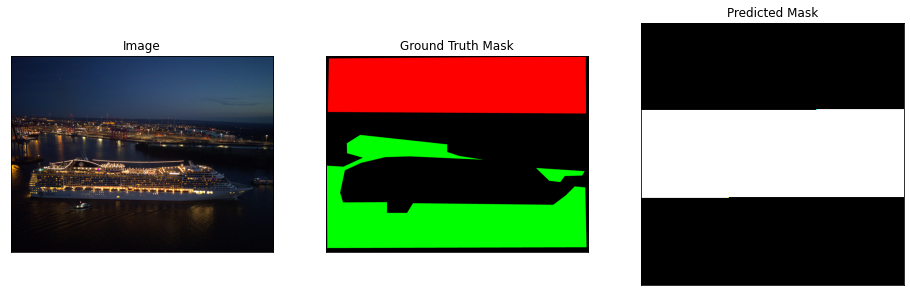

In [70]:

for i in range(1):
    n = np.random.choice(len(test_dataset))

    image_vis, mask = test_dataset_vis[n]
    image, gt_mask = test_dataset[n]


    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask = np.reshape(pr_mask,(320,320,3))
    visualize(
        image=image_vis,
        ground_truth_mask=mask,
        predicted_mask=pr_mask
    )

In [ ]:
a,b = test_dataset_vis[0]

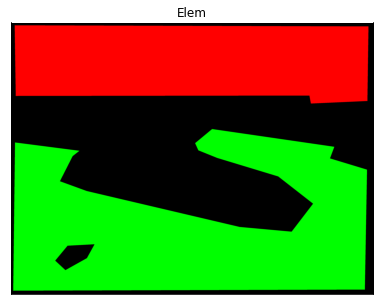

In [50]:
visualize(
    elem = b
)

(array([[[-2.0322802 , -2.0322802 , -2.0322802 , ..., -2.0322802 ,
          -2.0322802 , -2.0322802 ],
         [-2.0322802 , -2.0322802 , -2.0322802 , ..., -2.0322802 ,
          -2.0322802 , -2.0322802 ],
         [-2.0322802 , -2.0322802 , -2.0322802 , ..., -2.0322802 ,
          -2.0322802 , -2.0322802 ],
         ...,
         [-1.1589177 , -1.5699118 , -1.3301653 , ..., -1.3986642 ,
          -1.2959157 , -1.4842881 ],
         [-1.3301653 , -1.4329138 , -1.2616663 , ..., -1.3986642 ,
          -1.415789  , -1.2274168 ],
         [-1.2274168 , -1.3986642 , -1.2274168 , ..., -1.6726604 ,
          -1.2959157 , -1.3301653 ]],
 
        [[-1.9481792 , -1.9481792 , -1.9481792 , ..., -1.9481792 ,
          -1.9481792 , -1.9481792 ],
         [-1.9481792 , -1.9481792 , -1.9481792 , ..., -1.9481792 ,
          -1.9481792 , -1.9481792 ],
         [-1.9481792 , -1.9481792 , -1.9481792 , ..., -1.9481792 ,
          -1.9481792 , -1.9481792 ],
         ...,
         [-0.74019605, -1.0903361